
<font size = "5"> **Day 1: [Atomic Resolution STEM and Machine Learning](../MLSTEM2025.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />


[Download](https://github.com/gduscher/MLSTEM2025/raw/refs/heads/main/Day%201/5_Atom_Finding.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
   https://colab.research.google.com/github/gduscher/MLSTEM2025/blob/main/Day%201/5_Atom_Finding.ipynb)


# Simple Atom Position Detection 

part of the workshop of 

<font size = "5"> **[Machine Learning in Transmission Electron Microscopy](../MLSTEM2025.ipynb)**</font>


**Day1: Atomic Resolution STEM, Deep Convolutional Neural Networks, and Variational Auto Encoder**
<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Sergei Kalinin</td>
  </tr>
  <tr>
    <td colspan="2"><center>Microscopy Facilities</td> 
  </tr>
  
  <tr>
    <td colspan="2"><center>Materials Science & Engineering</td>
    <td></td>
  </tr>
  <tr>
    <td colspan="2"><center>Institute of Advanced Materials & Manufacturing</td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>
        
**June 2024**



## Import packages for figures and 
First we load the code to make figures from pyTEMlib
### Check Installed Packages

In [2]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.4.2':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
    !{sys.executable} -m pip install  --upgrade SimpleITK -q
    
print('done')

done


### Load the plotting and figure packages

In [3]:
%matplotlib widget

import matplotlib.pylab as plt
import numpy as np
import os
import sys
if 'google.colab' in sys.modules:
    from  google.colab import drive 
    from google.colab import output
    output.enable_custom_widget_manager()

%load_ext autoreload
%autoreload 2

sys.path.insert(0, '../../pyTEMlib')
import pyTEMlib.file_tools      # File input/ output library
import pyTEMlib.image_tools 
import pyTEMlib.probe_tools
import pyTEMlib.atom_tools

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ', pyTEMlib.__version__)

## Do all of registration

notebook_tags= {'notebook': 'Image_Registration',
                'notebook_version': '2024_05_14',
                'pyTEM version': pyTEMlib.__version__}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
pyTEM version:  0.2025.04.2


## Load an image stack :

Please, load an image stack. <br>

A stack of images is used to reduce noise, but for an added image the images have to be aligned to compensate for drift and other microscope instabilities.

In [4]:
if 'google.colab' in sys.modules:
    drive.mount("/content/drive")
    if not os.path.exists('./STO_Stack_10.dm3'):
        !wget  https://github.com/gduscher/MLSTEM2024//raw/main/example_data/STO_Stack_10.dm3
        
fileWidget = pyTEMlib.file_tools.FileWidget()

In [10]:
datasets = fileWidget.datasets
dataset = fileWidget.selected_dataset
# dataset = datasets['Channel_000']
if dataset.data_type.name != 'IMAGE_STACK':
    print('We really would need an image stack')
dataset.x.dimension_type = 'spatial'
dataset.y.dimension_type = 'spatial'
view = dataset.plot()
print(dataset)

AttributeError: 'FileWidget' object has no attribute 'selected_dataset'

## Complete Registration 

Takes a while, depending on your computer between 1 and 10 minutes

### Rigid Registration

Using sub-pixel accuracy registration determination method of:

Manuel Guizar-Sicairos, Samuel T. Thurman, and James R. Fienup, “Efficient subpixel image registration algorithms,” Optics Letters 33, 156-158 (2008). [DOI:10.1364/OL.33.000156](https://www.doi.org/%2010.1364/OL.33.000156)

as implemented in ``phase_cross_correlation`` function by ``scikit-image`` in the [registration](https://scikit-image.org/docs/dev/api/skimage.registration.html) package. 



[-1.  0.]
[0. 0.]
[-1.  0.]
[-1.  1.]
[0. 1.]
[ -7. -45.]
[-1.  1.]
[-1.  0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[-2.  1.]
[1. 1.]
[-1.  1.]
[1. 1.]
[-1.  1.]
[0. 1.]
[-1.  1.]
[0. 1.]
[-1.  1.]
[0. 1.]
[0. 1.]
[0. 1.]


z:  number (frame) of size (25,)

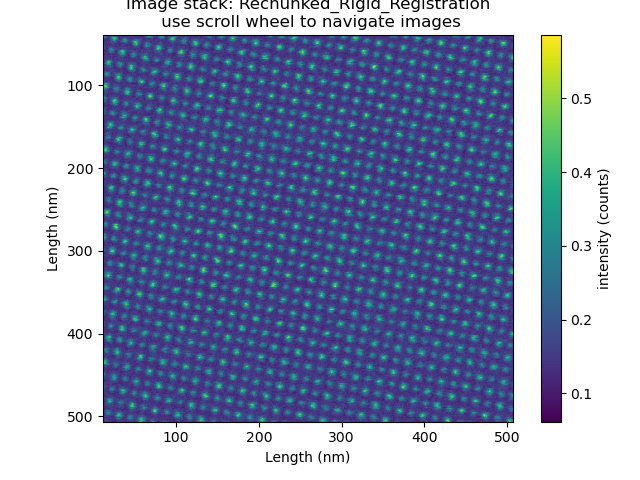

In [20]:
rigid_registered_dataset = pyTEMlib.image_tools.rigid_registration(dataset)
view = rigid_registered_dataset.plot()
dataset.z

In [22]:
rigid_registered_dataset.metadata

{'analysis': {'rigid_registration': {'drift': array([[12., 38.],
          [11., 38.],
          [11., 38.],
          [10., 38.],
          [ 9., 39.],
          [ 9., 40.],
          [ 2., -5.],
          [ 1., -4.],
          [ 0., -4.],
          [ 0., -3.],
          [ 0., -2.],
          [ 0., -1.],
          [ 0.,  0.],
          [-2.,  1.],
          [-1.,  2.],
          [-2.,  3.],
          [-1.,  4.],
          [-2.,  5.],
          [-2.,  6.],
          [-3.,  7.],
          [-3.,  8.],
          [-4.,  9.],
          [-4., 10.],
          [-4., 11.],
          [-4., 12.]]),
   'input_crop': [12, 508, 40, 507],
   'input_shape': (512, 512)}},
 'experiment': {}}

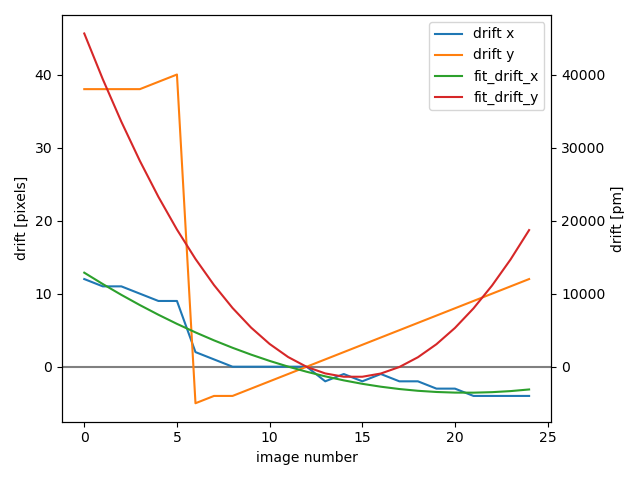

In [23]:
drift = rigid_registered_dataset.metadata['analysis']['rigid_registration']['drift']
polynom_degree = 2 # 1 is linear fit, 2 is parabolic fit, ...

x = np.linspace(0,drift.shape[0]-1,drift.shape[0])

line_fit_x = np.polyfit(x, drift[:,0], polynom_degree)
poly_x = np.poly1d(line_fit_x)
line_fit_y = np.polyfit(x, drift[:,1], polynom_degree)
poly_y = np.poly1d(line_fit_y)

plt.figure()
plt.axhline(color = 'gray')
plt.plot(x, drift[:,0], label = 'drift x')
plt.plot(x, drift[:,1], label = 'drift y')
plt.plot(x, poly_x(x),  label = 'fit_drift_x')
plt.plot(x, poly_y(x),  label = 'fit_drift_y')

plt.legend();
ax_pixels = plt.gca()
ax_pixels.step(1, 1)

scaleX = (rigid_registered_dataset.x[1]-rigid_registered_dataset.x[0])*1000.  #in pm

ax_pm = ax_pixels.twinx()
x_1, x_2 = ax_pixels.get_ylim()

ax_pm.set_ylim(x_1*scaleX, x_2*scaleX)

ax_pixels.set_ylabel('drift [pixels]')
ax_pm.set_ylabel('drift [pm]')
ax_pixels.set_xlabel('image number');
plt.tight_layout()


### Non-Rigid Registration

Here we use the **Diffeomorphic Demon Non-Rigid Registration** as provided by **simpleITK**.  

Please Cite: 
* [simpleITK](http://www.simpleitk.org/SimpleITK/project/parti.html)
    
    and
    
* [T. Vercauteren, X. Pennec, A. Perchant and N. Ayache *Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy* The Insight Journal, 2007](http://hdl.handle.net/1926/510)

In [24]:
non_rigid_registered = pyTEMlib.image_tools.demon_registration(rigid_registered_dataset)

  0%|          | 0/25 [00:00<?, ?it/s]

:-)
You have successfully completed Diffeomorphic Demons Registration


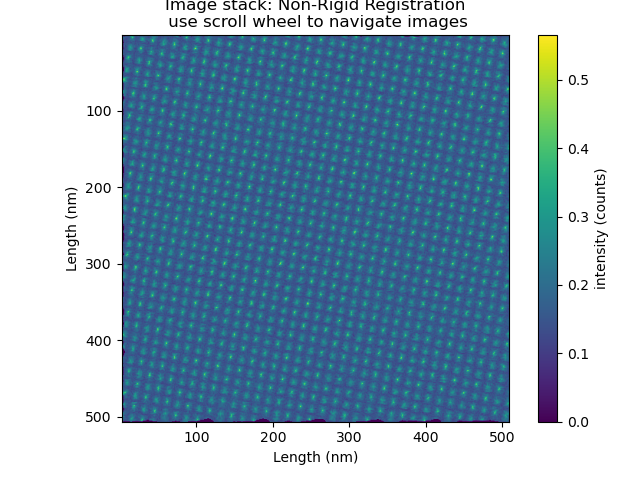

In [7]:
view= non_rigid_registered.plot()

datasets['Log_000'] = non_rigid_registered

## Find Atom Positions
### Lucy -Richardson Deconvolution

Lucy - Richardson Deconvolution removes noise and convolutes the intensity back into the atom (columns).

Here we use a slightly modified Lucy - Richardson Deconvolution which stops when converged.

Ideally the atom_size should be as large as the atoms in the image.

A good Lucy-Richardson Deconvolution should result in an image with atoms of a radius of about 2 pixels.

The number of steps to convergence should be less than 300 for a good approximation of atom_size.
> we use the non-rigid registered datset


In [4]:
# ------- Input ------
atoms_size = .5 # in nm
# --------------------

image = non_rigid_registered.sum(axis=0)

out_tags = {}
image.metadata['experiment']= {'convergence_angle': 30, 'acceleration_voltage': 200000.}

scale_x = image.x.slope
gauss_diameter = atoms_size/scale_x
gauss_probe = pyTEMlib.probe_tools.make_gauss(image.shape[0], image.shape[1], gauss_diameter)

print('Deconvolution of ', dataset.title)
LR_dataset = pyTEMlib.image_tools.decon_lr(image, gauss_probe, verbose=False)
datasets['Log_001'] = LR_dataset
extent = LR_dataset.get_extent([0,1])
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(image.T, extent = extent,vmax=np.median(np.array(image))+3*np.std(np.array(image)))
ax[1].imshow(LR_dataset.T, extent = extent, vmax=np.median(np.array(LR_dataset))+3*np.std(np.array(LR_dataset)));

NameError: name 'non_rigid_registered' is not defined

## Atom Detection

Choose threshold and atom size so that all atoms or at least all bright atoms of an unit cell are found 

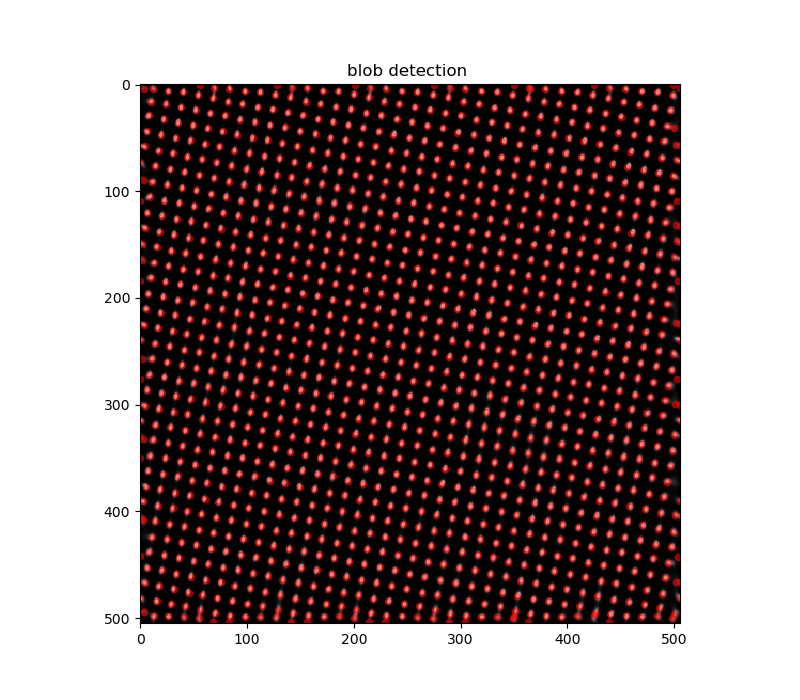

In [9]:
import skimage
# ------- Input ------
threshold = 0.9 #usally between 0.01 and 0.9  the smaller the more atoms
atom_size = .06 #in nm  
# ----------------------


image = LR_dataset
#image = image_choice.dataset
scale_x = image.x.slope
blobs =  skimage.feature.blob_log(image, max_sigma=atom_size/scale_x, threshold=threshold)

fig1, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
plt.title("blob detection ")

plt.imshow(image.T, interpolation='nearest',cmap='gray', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
plt.scatter(blobs[:, 0], blobs[:, 1], c='r', s=20, alpha = .5);

In [10]:
image_choice = pyTEMlib.file_tools.ChooseDataset(datasets)  

Dropdown(description='select dataset:', options=('Channel_000: 20-3D Stack_10', 'Log_000: Non-Rigid Registrati…

using radius  3 pixels


  0%|          | 0/1254 [00:00<?, ?it/s]

C:\Users\gduscher\Documents\Github\MLSTEM2024\Day1\../../pyTEMlib\pyTEMlib\probe_tools.py:13: RuntimeWarning: invalid value encountered in divide
  probe = g / g.sum() * intensity


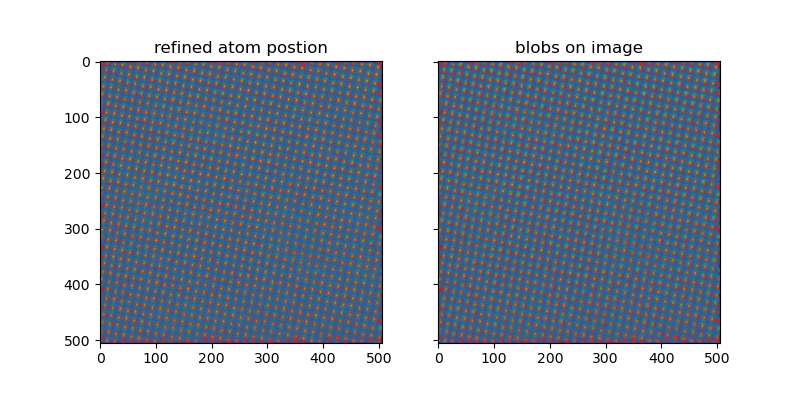

In [11]:
# ------- Input ------
atom_radius = 3  # in pixel
# ----------------------

if image_choice.dataset.data_type.name == 'IMAGE_STACK':
    image = image_choice.dataset.sum(axis=0)
else:
    image = image_choice.dataset

#atoms = atom_group['atoms'][()]
atoms = blobs
image = image-image.min()

#atom_radius = 2
MaxInt = 0
MinInt = 0 
maxDist = 2
sym = pyTEMlib.atom_tools.atom_refine(np.array(image), atoms, atom_radius, max_int = 0, min_int = 0, max_dist = 2)
refined_atoms = np.array(sym['atoms'])

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(image.T)
ax[0].scatter(refined_atoms[:,0],refined_atoms[:,1],  s=10, alpha = 0.3, color = 'red')
ax[0].set_title('refined atom postion')
ax[1].imshow(image.T)
ax[1].scatter(atoms[:, 0], atoms[:, 1], c='r', s=10, alpha = .3);
ax[1].set_title('blobs on image');

In [36]:
file = pyTEMlib.file_tools.save_dataset(datasets)

C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\pyNSID\io\hdf_utils.py:381: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\pyNSID\io\hdf_utils.py:381: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\pyNSID\io\hdf_io.py:111: UserWarning: main_data_name should not contain the "-" character. Reformatted name from:Non-Rigid Registration to Non_Rigid Registration
  warn('main_data_name should not contain the "-" character. Reformatted'
C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\pyNSID\io\hdf_utils.py:381: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


<HDF5 group "/Measurement_000" (3 members)>

## Appendix

### Demon Registration

Here we use the **Diffeomorphic Demon Non-Rigid Registration** as provided by **simpleITK**.  

Please Cite: 
* [simpleITK](http://www.simpleitk.org/SimpleITK/project/parti.html)
    
    and
    
* [T. Vercauteren, X. Pennec, A. Perchant and N. Ayache *Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy* The Insight Journal, 2007](http://hdl.handle.net/1926/510)

This Non-Rigid Registration consists of the following steps:

- determine ``reference`` image
    - For this we use the average of the rigid registered stack
    - this averaged stack is then smeared with a Gaussian of sigma 2 pixel to reduce noise
    - under the assumption that high frequency scan distortions cancel out over several images, we, therefore, obtained the center of mass of the atoms. 

- perform the ``demon registration`` filter to determine a distortion matrix
    - each single image of a stack is first smeared with a Gaussian of sigma of 2pixels
    - then the deformation matrix is determined for these images
    - the deformation matrix is a matrix where each pixel has a vector ( x, and y value) for the relative shift of this pixel.
    
- This deformation matrix is used to ``transform`` the image
	- The transformation is performed on the original image.
	- Important, here, is to set the interpolator method, (the image needs to be interpolated because the new pixels are not on an integer grid.)
    
    
Let's see what the different interpolators do.

|Method	| RMS contrast |	Standard |	Mean |
|-------|:--------------|:-------------|:-------|
|original   |0.1965806	|0.07764114	|0.3949583
|Linear	    |0.20159315	|0.079470366	|0.39421165
|BSpline	|0.20162606	|0.0794831 	|0.39421043
|Gaussian	|0.14310582	|0.056414302 	|0.39421389
|Hamming	|0.20163293	|0.07948672 	|0.39421496

The Gaussian interpolator as the only one seems to smear the signal.

We will use the ``Bspline`` method a fast and simple method that does not introduce spurious features and does not smear the signal.


#### Full Code of Demon registration 